<a href="https://colab.research.google.com/github/chokun7788/PoopforAIB/blob/main/VeryGood!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# กำหนด path ของข้อมูล
train_dir = "/content/drive/MyDrive/dataset/train/"
valid_dir = "/content/drive/MyDrive/dataset/valid/"
test_dir = "/content/drive/MyDrive/dataset/test/"

# การเพิ่มข้อมูล (augmentation) เฉพาะในโฟลเดอร์ Mucus, Green, Blood
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,  # เพิ่มการหมุน
    width_shift_range=0.2,  # ขยับตำแหน่งภาพ
    height_shift_range=0.2
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# ตรวจสอบและเปลี่ยนชื่อไฟล์ที่มีอักขระที่ไม่เหมาะสม
def rename_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png')):  # ตรวจสอบว่าเป็นไฟล์รูปภาพ
            new_filename = filename.replace('-', '_').replace(' ', '_')  # แทนที่ - และ space ด้วย _
            os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))

# เปลี่ยนชื่อไฟล์ในโฟลเดอร์ Mucus, Green, Blood
rename_files('/content/drive/MyDrive/dataset/train/Mucus/')
rename_files('/content/drive/MyDrive/dataset/train/Green/')
rename_files('/content/drive/MyDrive/dataset/train/Blood/')

# เฉพาะใน 3 โฟลเดอร์ (Mucus, Green, Blood)
train_generator = {sub_dir: train_datagen.flow_from_directory(os.path.join(train_dir, sub_dir), target_size=(224, 224), batch_size=32, class_mode='categorical') for sub_dir in ['Mucus', 'Green', 'Blood']}
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

# สร้างโมเดลโดยใช้ Pre-trained ResNet50 (ปิดใช้งาน fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze บาง layers ของ ResNet50 (ทำการ fine-tune)
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Unfreeze 20 layers สุดท้าย
    layer.trainable = False

# สร้างโมเดลใหม่
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # ป้องกัน overfitting
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(train_generator['Mucus'].class_indices), activation='softmax')  # ปรับเป็นจำนวน class ที่ต้องการ
])

# ใช้ optimizer ด้วย learning rate ที่ต่ำ
optimizer = Adam(learning_rate=1e-5)

# คอมไพล์โมเดล
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ใช้ EarlyStopping เพื่อหยุดการฝึกเมื่อไม่เห็นการปรับปรุงใน validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ใช้ ModelCheckpoint เพื่อบันทึกโมเดลที่ดีที่สุด (การประเมินโดย validation accuracy)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/dataset/retailclass/my_best_model.h5', monitor='val_loss', save_best_only=True)

# ใช้ ReduceLROnPlateau เพื่อปรับลด learning rate เมื่อไม่เห็นการปรับปรุง
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# ฝึกโมเดล
history = model.fit(
    train_generator['Mucus'], steps_per_epoch=train_generator['Mucus'].samples // train_generator['Mucus'].batch_size, epochs=20, validation_data=valid_generator, validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[early_stopping, checkpoint, reduce_lr], verbose=1
)

# โหลดโมเดลที่ดีที่สุด
best_model = models.load_model('/content/drive/MyDrive/dataset/retailclass/my_best_model.h5')

# ประเมินผลบนชุดข้อมูล test
test_loss, test_acc = best_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# ทำนายผลลัพธ์จาก test set
y_pred = best_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# แปลงค่าที่ทำนายให้เป็น class index โดยการเลือก class ที่มีความน่าจะเป็นสูงสุด
y_pred_classes = np.argmax(y_pred, axis=1)

# ดึง label จริงจาก test set
y_true = test_generator.classes

# คำนวณ F1 score และค่าประเมินอื่นๆ
report = classification_report(y_true, y_pred_classes)
print(report)

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# แสดงผลด้วย heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(), cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 418 images belonging to 6 classes.
Found 423 images belonging to 6 classes.


ValueError: The PyDataset has length 0

In [22]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# กำหนด path ของข้อมูล
base_dir = "/content/drive/MyDrive/dataset" # กำหนด base directory เพื่อความสะดวก
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

# กำหนดพารามิเตอร์การเพิ่มข้อมูล (augmentation)
# เราจะใช้ datagen ตัวเดียวกันนี้สำหรับ train, valid, และ test ตามที่คุณต้องการ
# (โปรดทราบข้อควรระวังเกี่ยวกับการ augment test/valid set)
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2
)

# สำหรับ valid และ test set หากคุณต้องการแค่ rescale โดยไม่ augment แบบอื่นๆ
# สามารถสร้าง ImageDataGenerator แยกต่างหากได้ดังนี้:
# basic_datagen = ImageDataGenerator(rescale=1./255)
# แต่จากคำขอ เราจะใช้ augmented_datagen สำหรับทุกชุด

# โหลดข้อมูลจากโฟลเดอร์ train พร้อม Augmentation
print("Training data:")
train_generator = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True # ควร shuffle ข้อมูล train
)

# โหลดข้อมูลจากโฟลเดอร์ validation พร้อม Augmentation (ตามคำขอ)
print("\nValidation data:")
valid_generator = augmented_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False # โดยทั่วไป validation/test ไม่จำเป็นต้อง shuffle
)

# โหลดข้อมูลจากโฟลเดอร์ test พร้อม Augmentation (ตามคำขอ)
print("\nTest data:")
test_generator = augmented_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False # โดยทั่วไป validation/test ไม่จำเป็นต้อง shuffle
)

# ตรวจสอบจำนวนข้อมูลในแต่ละโฟลเดอร์ย่อยของ train
print("\n--- Image counts in train subfolders ---")
if os.path.exists(os.path.join(train_dir, 'Blood')):
    print(f"Blood images in train: {len(os.listdir(os.path.join(train_dir, 'Blood')))}")
else:
    print(f"Train Blood folder not found at: {os.path.join(train_dir, 'Blood')}")

if os.path.exists(os.path.join(train_dir, 'Mucus')):
    print(f"Mucus images in train: {len(os.listdir(os.path.join(train_dir, 'Mucus')))}")
else:
    print(f"Train Mucus folder not found at: {os.path.join(train_dir, 'Mucus')}")

if os.path.exists(os.path.join(train_dir, 'Green')):
    print(f"Green images in train: {len(os.listdir(os.path.join(train_dir, 'Green')))}")
else:
    print(f"Train Green folder not found at: {os.path.join(train_dir, 'Green')}")

# ตรวจสอบจำนวนข้อมูลในแต่ละโฟลเดอร์ย่อยของ valid
print("\n--- Image counts in valid subfolders ---")
if os.path.exists(os.path.join(valid_dir, 'Blood')):
    print(f"Blood images in valid: {len(os.listdir(os.path.join(valid_dir, 'Blood')))}")
else:
    print(f"Valid Blood folder not found at: {os.path.join(valid_dir, 'Blood')}")

if os.path.exists(os.path.join(valid_dir, 'Mucus')):
    print(f"Mucus images in valid: {len(os.listdir(os.path.join(valid_dir, 'Mucus')))}")
else:
    print(f"Valid Mucus folder not found at: {os.path.join(valid_dir, 'Mucus')}")

if os.path.exists(os.path.join(valid_dir, 'Green')):
    print(f"Green images in valid: {len(os.listdir(os.path.join(valid_dir, 'Green')))}")
else:
    print(f"Valid Green folder not found at: {os.path.join(valid_dir, 'Green')}")

# ตรวจสอบจำนวนข้อมูลในแต่ละโฟลเดอร์ย่อยของ test
print("\n--- Image counts in test subfolders ---")
if os.path.exists(os.path.join(test_dir, 'Blood')):
    print(f"Blood images in test: {len(os.listdir(os.path.join(test_dir, 'Blood')))}")
else:
    print(f"Test Blood folder not found at: {os.path.join(test_dir, 'Blood')}")

if os.path.exists(os.path.join(test_dir, 'Mucus')):
    print(f"Mucus images in test: {len(os.listdir(os.path.join(test_dir, 'Mucus')))}")
else:
    print(f"Test Mucus folder not found at: {os.path.join(test_dir, 'Mucus')}")

if os.path.exists(os.path.join(test_dir, 'Green')):
    print(f"Green images in test: {len(os.listdir(os.path.join(test_dir, 'Green')))}")
else:
    print(f"Test Green folder not found at: {os.path.join(test_dir, 'Green')}")


# แสดง class indices ที่ ImageDataGenerator กำหนด
print(f"\nTrain generator class indices: {train_generator.class_indices}")
print(f"Validation generator class indices: {valid_generator.class_indices}")
print(f"Test generator class indices: {test_generator.class_indices}")

# แสดงจำนวนภาพทั้งหมดที่ generator จะสร้าง (รวม augmented images ต่อ epoch)
print(f"\nTotal training samples: {train_generator.samples}")
print(f"Total validation samples: {valid_generator.samples}")
print(f"Total test samples: {test_generator.samples}")

Training data:
Found 3201 images belonging to 6 classes.

Validation data:
Found 418 images belonging to 6 classes.

Test data:
Found 423 images belonging to 6 classes.

--- Image counts in train subfolders ---
Blood images in train: 109
Mucus images in train: 32
Green images in train: 109

--- Image counts in valid subfolders ---
Blood images in valid: 18
Mucus images in valid: 18
Green images in valid: 14

--- Image counts in test subfolders ---
Blood images in test: 18
Mucus images in test: 19
Green images in test: 14

Train generator class indices: {'Blood': 0, 'Diarrhea': 1, 'Green': 2, 'Mucus': 3, 'Normal': 4, 'Yellow': 5}
Validation generator class indices: {'Blood': 0, 'Diarrhea': 1, 'Green': 2, 'Mucus': 3, 'Normal': 4, 'Yellow': 5}
Test generator class indices: {'Blood': 0, 'Diarrhea': 1, 'Green': 2, 'Mucus': 3, 'Normal': 4, 'Yellow': 5}

Total training samples: 3201
Total validation samples: 418
Total test samples: 423


Renaming files in train directory...
Renaming files in valid directory...
Renaming files in test directory...
Training classes found: ['Blood', 'Diarrhea', 'Green', 'Mucus', 'Normal', 'Yellow']
Total training images: 3201
Total validation images: 418
Total test images: 423


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,692,038 (98.01 MB)

 Trainable params: 11,035,654 (42.10 MB)

 Non-trainable params: 14,656,384 (55.91 MB)


Starting model training...
Epoch 1/50
  1/101 ━━━━━━━━━━━━━━━━━━━━ 1:18:20 47s/step - accuracy: 0.1875 - loss: 2.0696Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/is_that_yellow_stool_or_light_brown_v0_3s2s73k6ryxb1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Normal/is_that_yellow_stool_or_light_brown_v0_3s2s73k6ryxb1.png')
  2/101 ━━━━━━━━━━━━━━━━━━━━ 17:23 11s/step - accuracy: 0.1797 - loss: 2.0851  Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/does_this_look_normal_v0_2z0a5icyzwte1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Normal/does_this_look_normal_v0_2z0a5icyzwte1.png')
  3/101 ━━━━━━━━━━━━━━━━━━━━ 27:28 17s/step - accuracy: 0.1719 - loss: 2.1053Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/heres_my_last_few_poops_ive_had_v0_5mzicpy40zte1.png: [Errno 2] No such file or directory: np.str_('/conte

101/101 ━━━━━━━━━━━━━━━━━━━━ 2487s 24s/step - accuracy: 0.2790 - loss: 1.7526 - val_accuracy: 0.4402 - val_loss: 1.2995 - learning_rate: 1.0000e-05
Epoch 2/50
  1/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 944ms/step - accuracy: 0.5938 - loss: 0.8929Error loading or processing image /content/drive/MyDrive/dataset/train/Diarrhea/what_is_this_yellow_orange_smooth_lump_stools_vary_from_v0_3yy7b9g8ntja1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Diarrhea/what_is_this_yellow_orange_smooth_lump_stools_vary_from_v0_3yy7b9g8ntja1.png')
  2/101 ━━━━━━━━━━━━━━━━━━━━ 1:00 612ms/step - accuracy: 0.5625 - loss: 0.9257Error loading or processing image /content/drive/MyDrive/dataset/train/Diarrhea/best_of_both_worlds_v0_dvghv7gx04te1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Diarrhea/best_of_both_worlds_v0_dvghv7gx04te1.png')
Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/early_sunday_morning_

101/101 ━━━━━━━━━━━━━━━━━━━━ 84s 827ms/step - accuracy: 0.4926 - loss: 1.0430 - val_accuracy: 0.4689 - val_loss: 1.1801 - learning_rate: 1.0000e-05
Epoch 3/50
Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/early_sunday_morning_poop_v0_p2lhu2q927te1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Normal/early_sunday_morning_poop_v0_p2lhu2q927te1.png')
  1/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 1s/step - accuracy: 0.5312 - loss: 0.9485Error loading or processing image /content/drive/MyDrive/dataset/train/Diarrhea/my_stormatch_intestine_make_noises_every_minute_what_should_v0_c9tjl83yi0ue1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Diarrhea/my_stormatch_intestine_make_noises_every_minute_what_should_v0_c9tjl83yi0ue1.png')
  4/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 668ms/step - accuracy: 0.5495 - loss: 0.9327Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/does_it_

101/101 ━━━━━━━━━━━━━━━━━━━━ 86s 854ms/step - accuracy: 0.5900 - loss: 0.9269 - val_accuracy: 0.5431 - val_loss: 1.1041 - learning_rate: 1.0000e-05
Epoch 4/50
  1/101 ━━━━━━━━━━━━━━━━━━━━ 1:34:48 57s/step - accuracy: 0.5625 - loss: 0.9274Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/is_this_malnutrition_or_malabsorption_poop_v0_junlv488o3te1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Normal/is_this_malnutrition_or_malabsorption_poop_v0_junlv488o3te1.png')
Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/does_it_look_normal_today_v0_71i2t36o8lte1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Normal/does_it_look_normal_today_v0_71i2t36o8lte1.png')
 12/101 ━━━━━━━━━━━━━━━━━━━━ 1:03 717ms/step - accuracy: 0.6338 - loss: 0.8550Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/is_that_yellow_stool_v0_18iprq92xv9a1_(1).

101/101 ━━━━━━━━━━━━━━━━━━━━ 137s 802ms/step - accuracy: 0.6312 - loss: 0.8618 - val_accuracy: 0.5646 - val_loss: 1.1040 - learning_rate: 1.0000e-05
Epoch 5/50
Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/early_sunday_morning_poop_v0_p2lhu2q927te1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Normal/early_sunday_morning_poop_v0_p2lhu2q927te1.png')
  3/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 677ms/step - accuracy: 0.6684 - loss: 0.8089Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/pale_you_would_say_v0_p7fwdpno5use1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Normal/pale_you_would_say_v0_p7fwdpno5use1.png')
Error loading or processing image /content/drive/MyDrive/dataset/train/Diarrhea/best_of_both_worlds_v0_dvghv7gx04te1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Diarrhea/best_of_both_worlds_v0_dvghv7gx0

101/101 ━━━━━━━━━━━━━━━━━━━━ 88s 863ms/step - accuracy: 0.6439 - loss: 0.8313 - val_accuracy: 0.5981 - val_loss: 1.0750 - learning_rate: 1.0000e-05
Epoch 6/50
  3/101 ━━━━━━━━━━━━━━━━━━━━ 59s 610ms/step - accuracy: 0.7118 - loss: 0.7374Error loading or processing image /content/drive/MyDrive/dataset/train/Diarrhea/does_this_look_like_blood_v0_owytnku0bvte1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Diarrhea/does_this_look_like_blood_v0_owytnku0bvte1.png')
  5/101 ━━━━━━━━━━━━━━━━━━━━ 59s 622ms/step - accuracy: 0.7008 - loss: 0.7423Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/how_does_it_look_v0_p8c76zqbu3te1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Normal/how_does_it_look_v0_p8c76zqbu3te1.png')
  6/101 ━━━━━━━━━━━━━━━━━━━━ 58s 618ms/step - accuracy: 0.7012 - loss: 0.7406Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/is_this_malnutri

101/101 ━━━━━━━━━━━━━━━━━━━━ 80s 786ms/step - accuracy: 0.7199 - loss: 0.6196 - val_accuracy: 0.6364 - val_loss: 1.0546 - learning_rate: 2.0000e-06
Epoch 12/50
  1/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 963ms/step - accuracy: 0.7188 - loss: 0.6964Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/warning_pictures_of_stool_can_this_be_a_gallstone_im_14_and_v0_380t0xw5tlab1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Normal/warning_pictures_of_stool_can_this_be_a_gallstone_im_14_and_v0_380t0xw5tlab1.png')
  4/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 833ms/step - accuracy: 0.7559 - loss: 0.6600Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/heres_my_last_few_poops_ive_had_v0_833tgpy40zte1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Normal/heres_my_last_few_poops_ive_had_v0_833tgpy40zte1.png')
  5/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 778ms/step - accuracy: 0.7597 - loss: 0.

101/101 ━━━━━━━━━━━━━━━━━━━━ 85s 843ms/step - accuracy: 0.7260 - loss: 0.6378 - val_accuracy: 0.6292 - val_loss: 1.0489 - learning_rate: 2.0000e-06
Epoch 13/50
  4/101 ━━━━━━━━━━━━━━━━━━━━ 58s 599ms/step - accuracy: 0.7038 - loss: 0.6099Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/warning_pictures_of_stool_can_this_be_a_gallstone_im_14_and_v0_380t0xw5tlab1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Normal/warning_pictures_of_stool_can_this_be_a_gallstone_im_14_and_v0_380t0xw5tlab1.png')
 10/101 ━━━━━━━━━━━━━━━━━━━━ 54s 602ms/step - accuracy: 0.7110 - loss: 0.6089Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/heres_my_last_few_poops_ive_had_v0_833tgpy40zte1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Normal/heres_my_last_few_poops_ive_had_v0_833tgpy40zte1.png')
 11/101 ━━━━━━━━━━━━━━━━━━━━ 55s 615ms/step - accuracy: 0.7125 - loss: 0.608

101/101 ━━━━━━━━━━━━━━━━━━━━ 81s 805ms/step - accuracy: 0.7361 - loss: 0.5986 - val_accuracy: 0.6316 - val_loss: 1.0382 - learning_rate: 2.0000e-06
Epoch 17/50
  2/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 742ms/step - accuracy: 0.7734 - loss: 0.6247Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/does_it_look_healthy_today_v0_1ldz7alhuzse1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Normal/does_it_look_healthy_today_v0_1ldz7alhuzse1.png')
  4/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 785ms/step - accuracy: 0.7630 - loss: 0.5919Error loading or processing image /content/drive/MyDrive/dataset/train/Normal/i_have_blood_in_my_stool_should_i_be_worried_it_always_v0_36cd47ux43te1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/train/Normal/i_have_blood_in_my_stool_should_i_be_worried_it_always_v0_36cd47ux43te1.png')
  8/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 776ms/step - accuracy: 0.7434 - loss: 0.5941Error loading or


Evaluating on test set...
Error loading or processing image /content/drive/MyDrive/dataset/test/Blood/blood_in_stool_v0_usud6h9l2j8c1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/test/Blood/blood_in_stool_v0_usud6h9l2j8c1.png')
Error loading or processing image /content/drive/MyDrive/dataset/test/Blood/blood_in_stool_v0_usud6h9l2j8c1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/test/Blood/blood_in_stool_v0_usud6h9l2j8c1.png')
 7/14 ━━━━━━━━━━━━━━━━━━━━ 2:29 21s/step - accuracy: 0.7031 - loss: 0.6344Error loading or processing image /content/drive/MyDrive/dataset/test/Normal/does_this_look_like_normal_poop_healthy_shape_size_v0_1zao8navabte1.png: [Errno 2] No such file or directory: np.str_('/content/drive/MyDrive/dataset/test/Normal/does_this_look_like_normal_poop_healthy_shape_size_v0_1zao8navabte1.png')
 8/14 ━━━━━━━━━━━━━━━━━━━━ 2:12 22s/step - accuracy: 0.7041 - loss: 0.6310Error loading or processing image 

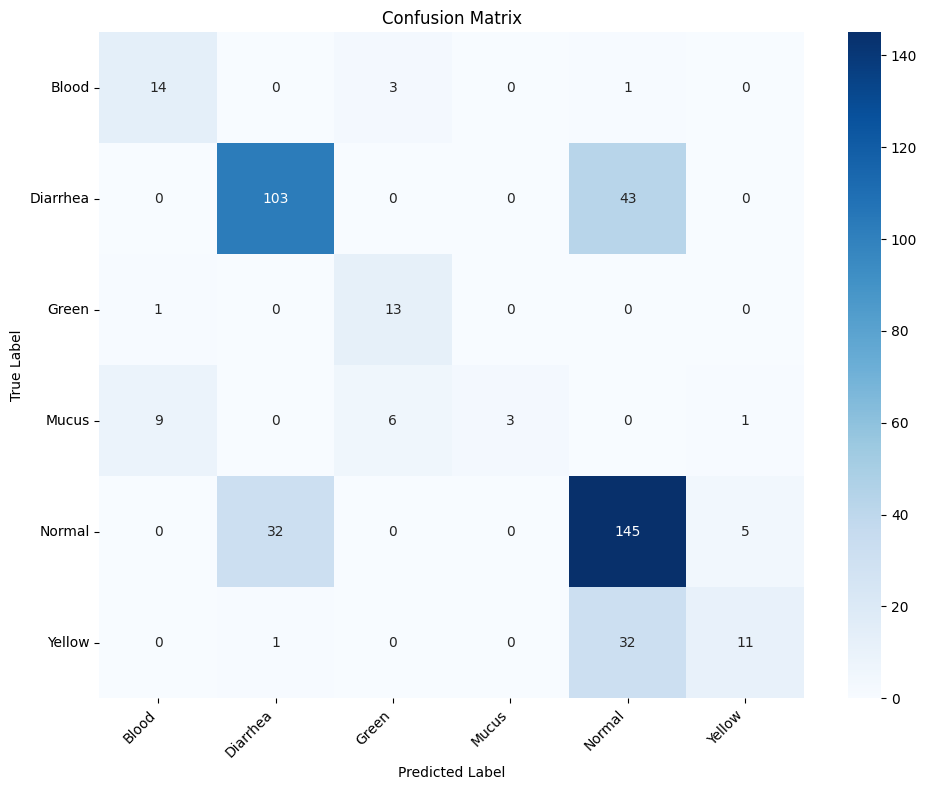

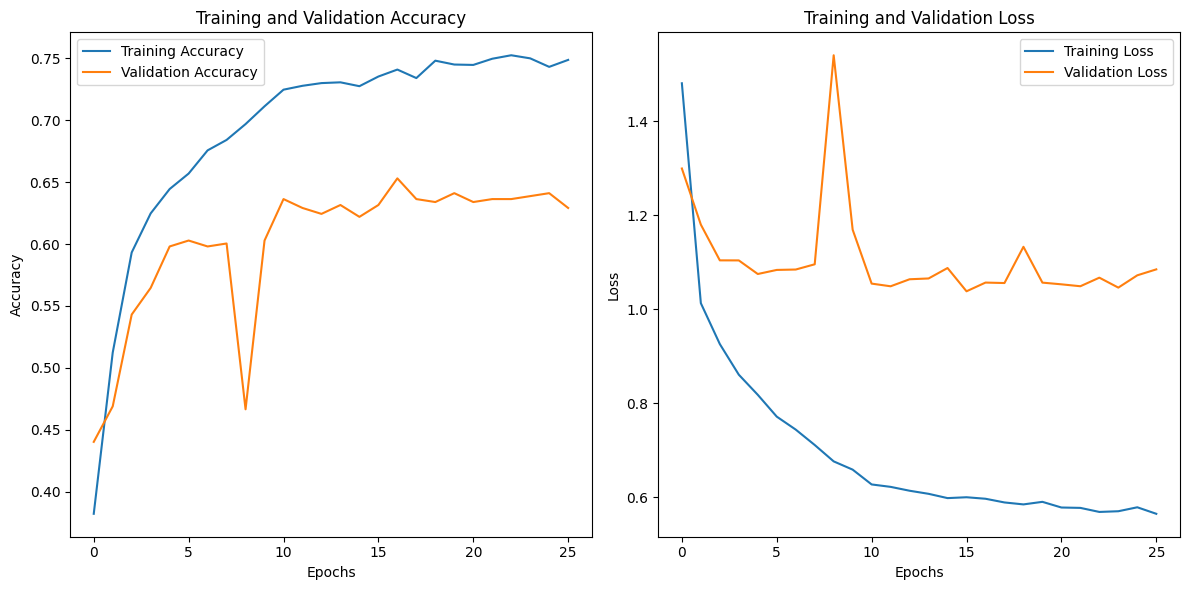

In [24]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image # เพิ่ม PIL เพื่อจัดการกับ truncated images

# ป้องกัน error จากภาพที่อาจจะไม่สมบูรณ์
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# กำหนด path ของข้อมูล
base_dir = "/content/drive/MyDrive/dataset/" # ตรวจสอบว่า path นี้ถูกต้อง
train_dir = os.path.join(base_dir, "train/")
valid_dir = os.path.join(base_dir, "valid/")
test_dir = os.path.join(base_dir, "test/")

# --- 1.ImageDataGenerator สำหรับ Augmentation (จะถูกใช้ภายใน Sequence) ---
augment_params = {
    'rescale': 1./255,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'rotation_range': 30,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2
}
# Generator นี้จะถูกใช้สำหรับ random_transform และ standardize
# rescale จะถูกรวมอยู่ในการทำงานของมัน
image_augmentor = ImageDataGenerator(**augment_params)
# Generator สำหรับ rescale เท่านั้น ในกรณีที่ภาพไม่ได้ถูก augment
image_rescaler = ImageDataGenerator(rescale=1./255)


# --- 2. ฟังก์ชันสำหรับรวบรวม Filepaths และ Labels ---
def get_filepaths_and_labels(directory):
    filepaths = []
    labels = []
    class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(class_dir, fname))
                labels.append(class_name)
    return filepaths, labels, class_names

# --- 3. สร้างคลาส CustomDataSequence ---
class CustomDataSequence(Sequence):
    def __init__(self, filepaths, labels, class_names_ordered, batch_size, target_dims,
                 classes_to_augment, augment_processor, rescale_processor, shuffle_on_epoch_end=True):
        self.filepaths = np.array(filepaths)
        self.labels_str = np.array(labels) # ชื่อคลาส (string)
        self.class_names_ordered = class_names_ordered # ลำดับของชื่อคลาสทั้งหมด
        self.class_to_int = {class_name: i for i, class_name in enumerate(class_names_ordered)}
        self.labels_int = np.array([self.class_to_int[label] for label in self.labels_str]) # ป้ายกำกับ (integer)

        self.batch_size = batch_size
        self.target_dims = target_dims
        self.num_classes = len(class_names_ordered)
        self.classes_to_augment = classes_to_augment # List of class names to augment, e.g., ['Blood', 'Mucus', 'Green']
        self.augment_processor = augment_processor # ImageDataGenerator instance for augmentation
        self.rescale_processor = rescale_processor # ImageDataGenerator for rescale only
        self.shuffle_on_epoch_end = shuffle_on_epoch_end
        self.indices = np.arange(len(self.filepaths))
        if self.shuffle_on_epoch_end:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.filepaths) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_filepaths = self.filepaths[batch_indices]
        batch_labels_str = self.labels_str[batch_indices]
        batch_labels_int = self.labels_int[batch_indices]

        X_batch = np.zeros((len(batch_filepaths), self.target_dims[0], self.target_dims[1], 3), dtype=np.float32)
        y_batch = np.zeros((len(batch_filepaths), self.num_classes), dtype=np.float32)

        for i, filepath in enumerate(batch_filepaths):
            try:
                img = load_img(filepath, target_size=self.target_dims)
                img_array = img_to_array(img) # ค่า 0-255

                current_class_name = batch_labels_str[i]

                if current_class_name in self.classes_to_augment:
                    # random_transform จะใช้ config ของ augment_processor รวมถึง rescale
                    processed_img_array = self.augment_processor.random_transform(img_array)
                    # standardize มักจะถูกเรียกหลังจาก random_transform เพื่อให้แน่ใจว่า mean/std normalization (ถ้ามี) ถูกใช้
                    # แต่ถ้า ImageDataGenerator มีแค่ rescale, random_transform ก็เพียงพอ
                    # ถ้า augment_processor มี rescale, ผลลัพธ์จาก random_transform จะถูก rescale แล้ว
                    X_batch[i] = processed_img_array
                else:
                    # สำหรับคลาสที่ไม่ augment, เราแค่ rescale
                    # ใช้ standardize จาก rescaler ซึ่งจะทำการ rescale ตามที่ตั้งค่าไว้
                    X_batch[i] = self.rescale_processor.standardize(img_array)

            except Exception as e:
                print(f"Error loading or processing image {filepath}: {e}")
                # อาจจะใส่ภาพ placeholder หรือข้ามไป
                X_batch[i] = np.zeros((self.target_dims[0], self.target_dims[1], 3), dtype=np.float32) # ภาพดำ

            y_batch[i] = to_categorical(batch_labels_int[i], num_classes=self.num_classes)

        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle_on_epoch_end:
            np.random.shuffle(self.indices)

# --- ตรวจสอบและเปลี่ยนชื่อไฟล์ (เหมือนเดิม) ---
def rename_files(directory):
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                    new_filename = filename.replace('-', '_').replace(' ', '_')
                    if new_filename != filename:
                        try:
                            os.rename(os.path.join(class_path, filename), os.path.join(class_path, new_filename))
                        except OSError as e:
                            print(f"Error renaming file {filename} in {class_path}: {e}")

print("Renaming files in train directory...")
rename_files(train_dir)
print("Renaming files in valid directory...")
rename_files(valid_dir)
print("Renaming files in test directory...")
rename_files(test_dir)


# --- 4. เตรียมข้อมูลสำหรับ Sequences ---
TARGET_DIMS = (224, 224)
BATCH_SIZE = 32
CLASSES_TO_AUGMENT = ['Blood', 'Mucus', 'Green'] # คลาสที่ต้องการ Augment

# Train data
train_filepaths, train_labels_str, all_class_names = get_filepaths_and_labels(train_dir)
if not all_class_names:
    raise ValueError(f"No classes found in training directory: {train_dir}. Please check the directory structure.")
print(f"Training classes found: {all_class_names}")
print(f"Total training images: {len(train_filepaths)}")

train_sequence = CustomDataSequence(train_filepaths, train_labels_str, all_class_names, BATCH_SIZE,
                                    TARGET_DIMS, CLASSES_TO_AUGMENT, image_augmentor, image_rescaler,
                                    shuffle_on_epoch_end=True)

# Validation data
valid_filepaths, valid_labels_str, _ = get_filepaths_and_labels(valid_dir)
print(f"Total validation images: {len(valid_filepaths)}")
valid_sequence = CustomDataSequence(valid_filepaths, valid_labels_str, all_class_names, BATCH_SIZE,
                                    TARGET_DIMS, CLASSES_TO_AUGMENT, image_augmentor, image_rescaler, # Augment valid set ตามคำขอ
                                    shuffle_on_epoch_end=False)

# Test data
test_filepaths, test_labels_str, _ = get_filepaths_and_labels(test_dir)
print(f"Total test images: {len(test_filepaths)}")
test_sequence = CustomDataSequence(test_filepaths, test_labels_str, all_class_names, BATCH_SIZE,
                                   TARGET_DIMS, CLASSES_TO_AUGMENT, image_augmentor, image_rescaler, # Augment test set ตามคำขอ
                                   shuffle_on_epoch_end=False)

NUM_CLASSES = len(all_class_names)
if NUM_CLASSES == 0:
    raise ValueError("Number of classes is 0. Cannot build model.")

# --- 5. สร้างและคอมไพล์โมเดล (เหมือนเดิม) ---
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(TARGET_DIMS[0], TARGET_DIMS[1], 3))
base_model.trainable = True
num_layers_to_freeze = len(base_model.layers) - 20
if num_layers_to_freeze < 0: num_layers_to_freeze = 0
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
for layer in base_model.layers[num_layers_to_freeze:]: # Ensure last layers are trainable
    layer.trainable = True


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks (เหมือนเดิม)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # เพิ่ม patience
checkpoint_dir = os.path.join(base_dir, 'retailclass_custom_seq/') # เปลี่ยนชื่อโฟลเดอร์ checkpoint
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_path = os.path.join(checkpoint_dir, 'my_best_model_custom_seq.h5')
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7) # ปรับ factor และ patience

# --- 6. ฝึกโมเดลโดยใช้ CustomDataSequence ---
print("\nStarting model training...")
history = model.fit(
    train_sequence,
    epochs=50, # เพิ่มจำนวน epochs ตามความเหมาะสม
    validation_data=valid_sequence,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=1
)

# --- 7. ประเมินผลและแสดงผล (ปรับเล็กน้อยสำหรับ Sequence) ---
print("\nLoading best model for evaluation...")
if os.path.exists(checkpoint_path):
    best_model = models.load_model(checkpoint_path)
else:
    print("Warning: Best model checkpoint not found. Using the model from the end of training.")
    best_model = model

print("\nEvaluating on test set...")
test_loss, test_acc = best_model.evaluate(test_sequence)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

print("\nPredicting on test set...")
y_pred_probabilities = best_model.predict(test_sequence)
y_pred_classes_indices = np.argmax(y_pred_probabilities, axis=1)

# ดึง true labels (integer indices) จาก test_sequence
y_true_indices = test_sequence.labels_int # ใช้ .labels_int จาก sequence โดยตรง

# ตรวจสอบว่าจำนวน y_pred_classes_indices สอดคล้องกับ y_true_indices ทั้งหมด
# CustomDataSequence จะจัดการ batch สุดท้ายที่อาจจะไม่เต็ม ดังนั้น y_pred ควรจะครอบคลุมทุก sample
# อย่างไรก็ตาม, y_true_indices จาก sequence.labels_int คือของทั้งหมด
# เราต้องแน่ใจว่า y_pred_classes_indices มีจำนวนเท่ากับจำนวน sample ทั้งหมดใน test_sequence
# predict() บน Sequence ควรจะให้ผลลัพธ์สำหรับทุก sample
if len(y_pred_classes_indices) != len(y_true_indices):
    print(f"Warning: Mismatch in number of predicted ({len(y_pred_classes_indices)}) and true ({len(y_true_indices)}) samples.")
    # อาจจะต้อง slice y_true_indices ให้เท่ากับจำนวนที่ predict ได้ ถ้าจำเป็น
    # y_true_indices = y_true_indices[:len(y_pred_classes_indices)]


print("\nClassification Report:")
# ใช้ all_class_names ซึ่งเป็น list ของชื่อคลาสที่เรียงลำดับแล้ว
# และ `labels` parameter ใน classification_report ควรเป็น indices ที่สอดคล้อง
try:
    report = classification_report(y_true_indices, y_pred_classes_indices,
                                   labels=np.arange(NUM_CLASSES),
                                   target_names=all_class_names, zero_division=0)
    print(report)
except ValueError as e:
    print(f"Error in classification_report: {e}")
    print(f"Unique true labels: {np.unique(y_true_indices)}")
    print(f"Unique predicted labels: {np.unique(y_pred_classes_indices)}")
    print(f"Number of classes for report: {NUM_CLASSES}, Target names: {all_class_names}")


print("\nConfusion Matrix:")
try:
    conf_matrix = confusion_matrix(y_true_indices, y_pred_classes_indices, labels=np.arange(NUM_CLASSES))
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=all_class_names,
                yticklabels=all_class_names, cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
except ValueError as e:
     print(f"Error in confusion_matrix: {e}")

# Plot training history (เหมือนเดิม)
if history:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()